<a href="https://colab.research.google.com/github/TimkaThymineTimiryazevskaya/sf_data_science/blob/main/AdultClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Обучение с учителем. Классификация
## <center> Предсказываем категорию дохода человека
<img src=https://blondeblog.ru/wp-content/uploads/2018/09/2.jpg.jpg>

In [3]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики

from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Описание задачи

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


### Знакомство с данными и их исследование

In [4]:
data = pd.read_csv('adult.zip')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [5]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [6]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

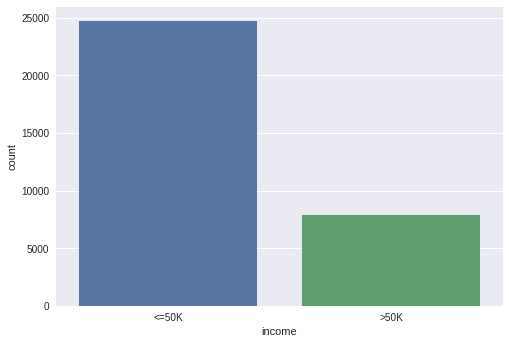

In [7]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [8]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [9]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

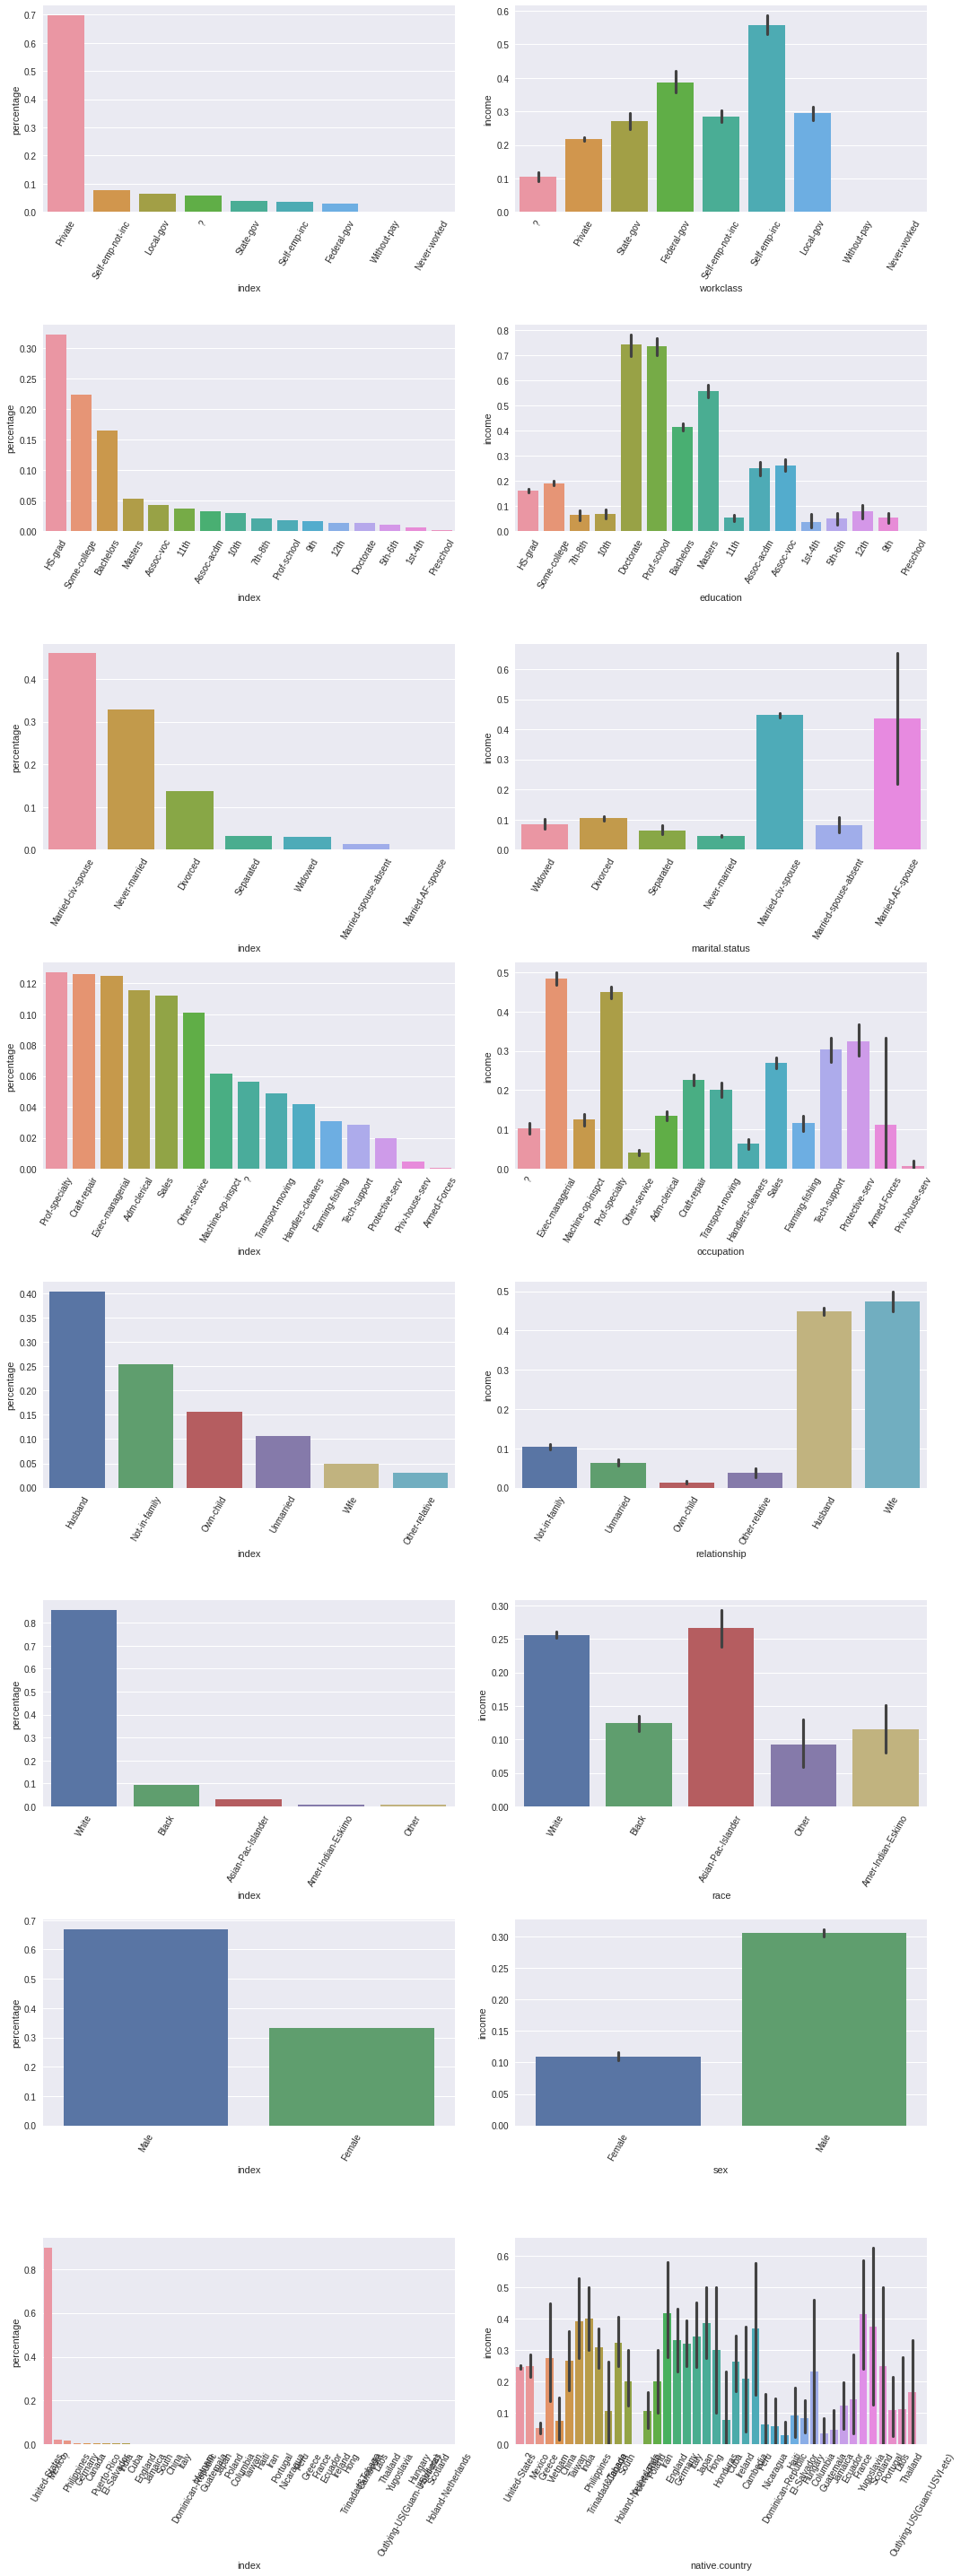

In [10]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [11]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Wife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [12]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [13]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [14]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,17800,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

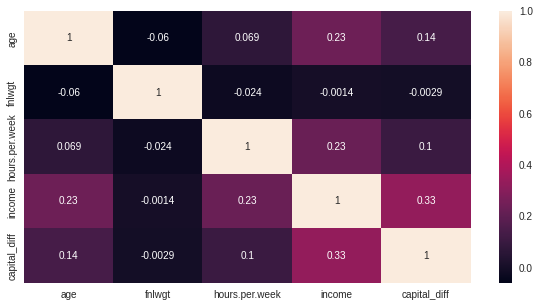

In [15]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True);

Кодируем текстовые категориальные признаки

In [16]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [17]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [19]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Моделирование + оценка модели

#### Логистическая регрессия

**Модель логистической регрессии:**

Модель логистической регрессии имеет следующий вид:
$$z_i= w_0+\sum_{j=0}^m w_j x_{ij}$$

$$\widehat{P_i}= \frac{1}{1+exp(-z_i)}$$

$$\widehat{y_i} = I_\gamma[\widehat{P_i}]$$

где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры логистической регрессии, $\widehat{P_i}$ - вероятность принадлежности к классу, $\gamma$ - порог вероятности (стандартный - 0.5)

Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 


В качестве функции потерь используем logloss - логистическая функция потерь.

$$L(\omega) = logloss = -\sum_{i=1}^{n}{(y_i log(\widehat{P_i}) + (1-y_i)log(1-\widehat{P_i}))} \Rightarrow min_\omega $$

Поиск параметров можно проводить с помощью численных методов. Например, градиентного спуска

In [20]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=1, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

Выводим отчет по метрикам для тренировочной и тестовой выборок

In [21]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19775
           1       0.72      0.58      0.64      6273

    accuracy                           0.84     26048
   macro avg       0.80      0.75      0.77     26048
weighted avg       0.84      0.84      0.84     26048

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4945
           1       0.72      0.58      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



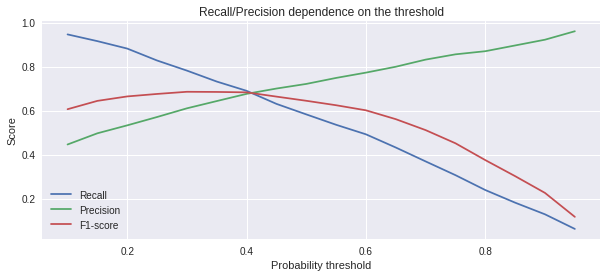

In [22]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [23]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4945
           1       0.68      0.69      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.79      0.79      6513
weighted avg       0.85      0.85      0.85      6513



#### Дерево решений

Дерево решений - ациклический связный граф. 

Построение дерева решений происходит по рекурсивному алгоритму $CART$ (псевдокод приведен в модуле).

В каждой вершине дерева задается решающее правило или предикат вида:

$$B_v(j, t) = I[x_j<= t]$$

Где $B_v$ - предикат в вершине под номер $v$, $j$ - номер признака, $t$ - пороговое значение признака 
Предикат разделяет выборку на две части: $Q_{left}$ - для которой условие верно, и $Q_{right}$ - для которой условие ложно.

На основе разделения выборки вершина порождает все новые вершины: левую и правую, для каждой из которых алгоритм повторяется, пока не выполнится некоторый критерий остановки.

Критерии остановки:
* достигнутая максимальная глубина (max_depth)
* количество наблюдений в листе меньше заданного числа (min_sample_leaf)
* неопределенность (функция ошибки) $L(j, t)$ в вершине равна 0 - все объекты, попавшие в вершину принадлежат одному классу.



Параметры $j$ и $t$ подбираются полным перебором (в sklearn он оптимизированы). Из всех возможных значений выбираются такие параметры, при которых функция ошибки (суммарная неопределенность) минимальна:
$$L(j, t)= \frac{n^{left}_v}{n_v} H(Q_{left}) + \frac{n^{right}_v}{n_v} H(Q_{right})  \Rightarrow min_{j, t} $$

Где $n^{left}_v$ и $n^{right}_v$ - размер выборок, попавших в левую и правую вершину соответственно 

$H(Q)$ называется критерием информативности. И он может быть двух видов:
1. Энтропия Шеннона:
$$H(Q) = \sum_{i=1}^{k}P_i log_2{P_i} $$
2. Критерий Джини:
$$H(Q) = \sum_{i=1}^{k}P_i (1-P_i) $$

In [65]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=5,
    max_depth=8,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.73
Test: 0.62


In [66]:
# #Создаем фигуру для визуализации графа
# fig = plt.figure(figsize=(25,20))
# #Строим граф дерева решений
# tree_graph = tree.plot_tree(
#     dt, #объект обученного дерева
#     feature_names=X_train.columns, #наименования факторов
#     class_names=["0 - <=50K", "1 - >50K"], #имена классов
#     filled=True, #расцветка графа
# );

#### Бэггинг. Случайный лес

**Бэггинг (bagging)** - алгоритм построения ансамбля путем параллельного обучения множества независимых друг от друга моделей. Предсказание для новых данных производится путем мажоритарного голосования или усреднения ответов

**Случайный лес (Random Forest)** - частный случай бэггинга над деревьями решений с методом случайных подпространств

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy', #критерий эффективности
    max_depth=3, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.67
Test: 0.67


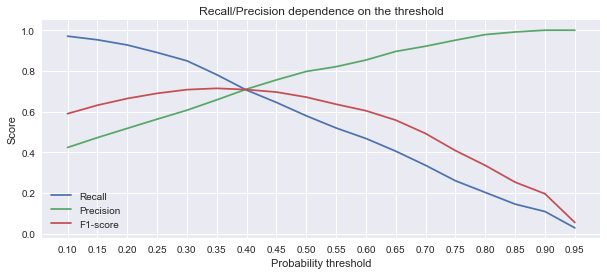

In [ ]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [ ]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4945
           1       0.66      0.78      0.71      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.83      0.81      6513
weighted avg       0.86      0.85      0.85      6513




**Задание**

In [67]:
churn_data = pd.read_csv('churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [68]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape
# (2509, 14)

(2509, 14)

In [69]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [70]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [71]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [72]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [73]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [74]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [75]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [77]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


In [36]:

log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [38]:
y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)
print(metrics.f1_score(y_train, y_train_predict))
print(metrics.f1_score(y_test, y_test_predict))

0.4899598393574298
0.47094801223241584


In [39]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train_poly.shape)

(1881, 454)


In [40]:
log_reg.fit(X_train_poly, y_train)
y_train_predict_poly = log_reg.predict(X_train_poly)
y_test_predict_poly = log_reg.predict(X_test_poly)
print(metrics.f1_score(y_train, y_train_predict_poly))
print(metrics.f1_score(y_test, y_test_predict_poly))

0.6552380952380952
0.6371191135734072


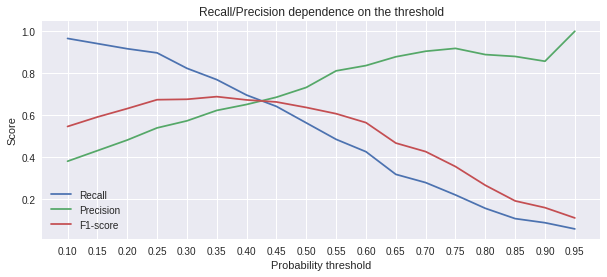

In [42]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [43]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628



In [44]:
diabetes_data = pd.read_csv('diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


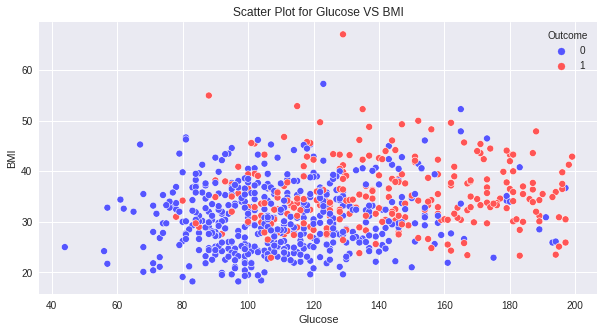

In [45]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('Scatter Plot for Glucose VS BMI');

In [46]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

In [47]:
from sklearn import tree

In [48]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

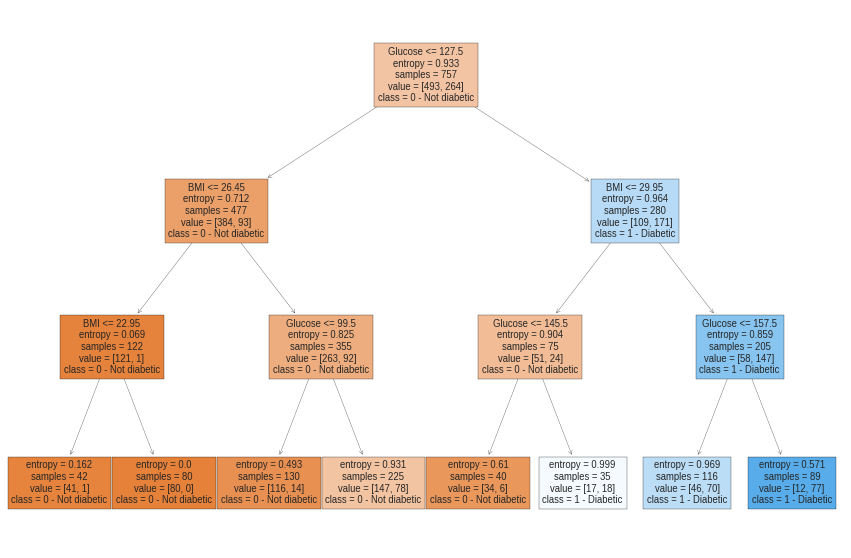

In [49]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [50]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))
# Predicted class: [1]

Predicted class: [1]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [51]:
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted probabilities: [[0.135 0.865]]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [52]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от 40 до 200, BMI — от 10 до 80
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(40, 200, 0.1),
        np.arange(10, 80, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(data=X, x='Glucose', y='BMI', hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


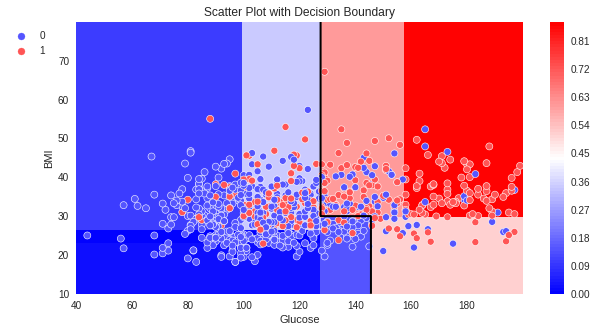

In [53]:
plot_probabilities_2d(X, y, dt_clf_2d)

In [54]:
y_pred = dt_clf_2d.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



In [55]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его длины
dt_clf_bad.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [56]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_bad.predict(X)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



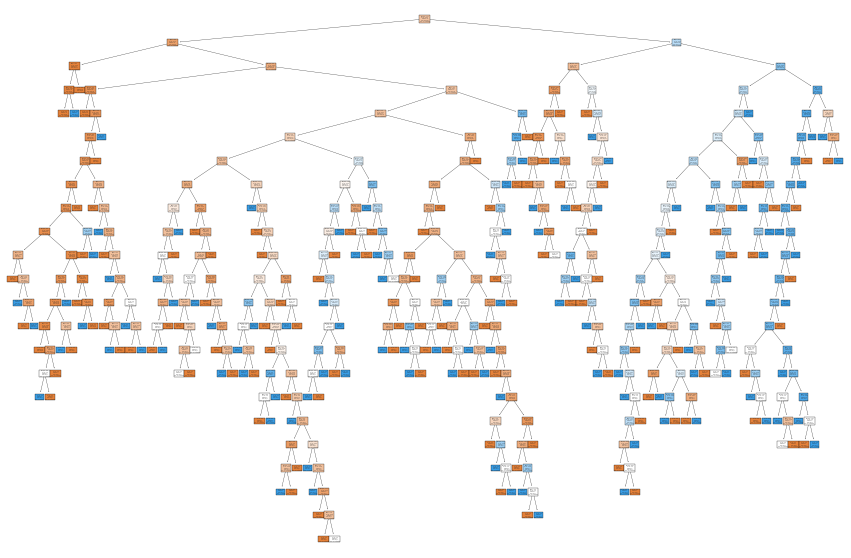

In [57]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф 
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [58]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

In [59]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)
 
#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



In [61]:
print(dt_clf_full.feature_importances_)


[0.02675774 0.36675873 0.03368236 0.04553664 0.24588118 0.14137465
 0.14000868]


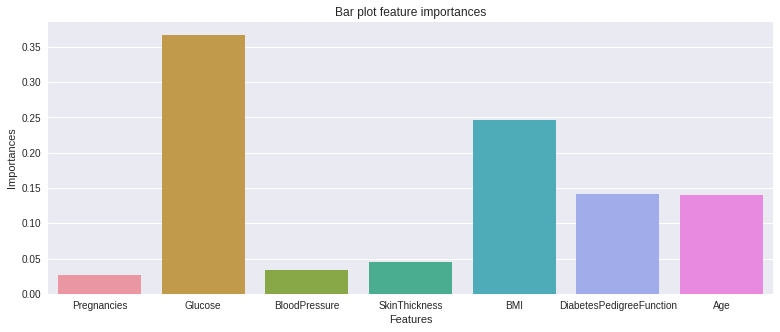

In [62]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = dt_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [64]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='gini', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X, y)
 
#Делаем предсказание класса
y_pred = dt_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       493
           1       0.85      0.73      0.78       264

    accuracy                           0.86       757
   macro avg       0.85      0.83      0.84       757
weighted avg       0.86      0.86      0.86       757



In [78]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf = 10,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X_train, y_train)
 
#Делаем предсказание класса
y_train_pred = dt_clf_full.predict(X_train)
y_test_pred = dt_clf_full.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1271
           1       0.80      0.65      0.72       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       424
           1       0.71      0.58      0.64       204

    accuracy                           0.79       628
   macro avg       0.76      0.73      0.74       628
weighted avg       0.78      0.79      0.78       628



In [79]:
#Создаём объект класса RandomForestClassifier
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10,
    random_state=42 #генератор случайных чисел
)
rf_clf_full.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       n_estimators=500, random_state=42)

In [80]:
#Делаем предсказание класса
y_train_pred = rf_clf_full.predict(X_train)
y_test_pred = rf_clf_full.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.86      0.64      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.82      1881
weighted avg       0.85      0.85      0.84      1881

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.59      0.66       204

    accuracy                           0.80       628
   macro avg       0.79      0.75      0.76       628
weighted avg       0.80      0.80      0.80       628



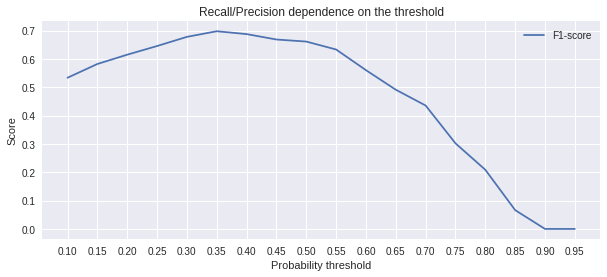

In [81]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf_clf_full.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [82]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628

